In [2]:
from itertools import permutations
import numpy as np
import pandas as pd
import sklearn
import sklearn.decomposition as dec
import sklearn.cluster as clu
import sklearn.datasets as ds
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
%matplotlib inline

### 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

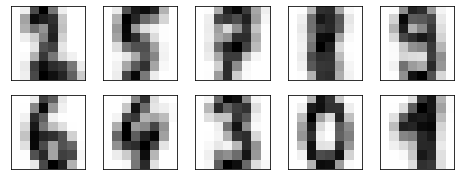

In [30]:
from sklearn.datasets import load_digits

N_CLUSTERS=10 # one for each digit?
digits = load_digits()

km = clu.KMeans(n_clusters=N_CLUSTERS)
km.fit(digits.data)

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = km.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [39]:
# make bool mask where for predict/target
clusters = km.predict(digits.data)
labels = np.zeros_like(clusters)

for i in range(10):
    # ???
    print(i)
    mask = (clusters == i)
    # why [0]?
    print(mode(digits.target[mask])[0])
    labels[mask] = mode(digits.target[mask])[0]

0
[2]
1
[5]
2
[7]
3
[8]
4
[9]
5
[6]
6
[4]
7
[3]
8
[0]
9
[1]


In [42]:
labels.shape

(1797,)

In [5]:
accuracy_score(digits.target, labels), confusion_matrix(digits.target, labels)

"""
Given an accuracy score of ~0.8, it appears that the model is able to predict the correct digit in ~80% of test cases. 
When inspecting the confusion matrix the second row appears to indicate that whatever digit is represented there is hardest to correctly identify. 
"""

(0.796883695047301,
 array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
        [  0,  55,  24,   1,   0,   1,   2,   0,  99,   0],
        [  1,   2, 148,  13,   0,   0,   0,   3,   8,   2],
        [  0,   0,   0, 155,   0,   2,   0,   7,   7,  12],
        [  0,   3,   0,   0, 166,   0,   0,   8,   4,   0],
        [  0,   0,   0,   1,   2, 136,   1,   0,   0,  42],
        [  1,   0,   0,   0,   0,   0, 177,   0,   3,   0],
        [  0,   0,   0,   0,   0,   0,   0, 177,   2,   0],
        [  0,   6,   3,   2,   0,   4,   2,   5, 102,  50],
        [  0,  20,   0,   6,   0,   6,   0,   7,   2, 139]], dtype=int64))

In [43]:
fowlkes_mallows_score(digits.target,labels)

"""
The FMI suggests that the two provided clusterings (target & predicted) are highly similar, while not perfect. 
This is consistent with what we've seen on the confusion matrix and accuracy score.

If I were able to account for the high level of inaccuracy shown on the 2nd row of the confusion matrix, this score would likely improve significantly.
"""

"\nThe FMI suggests that the two provided clusterings (target & predicted) are highly similar, while not perfect. \nThis is consistent with what we've seen on the confusion matrix and accuracy score.\n\nIf I were able to account for the high level of inaccuracy shown on the 2nd row of the confusion matrix, this score would likely improve significantly.\n"

### 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

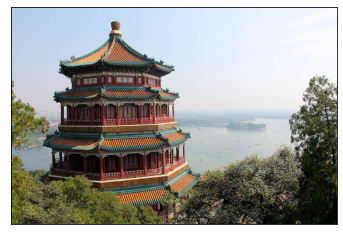

In [73]:
from sklearn.datasets import load_sample_image
from sklearn.cluster import MiniBatchKMeans

china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)

N_COLORS=45

kmeans = MiniBatchKMeans(N_COLORS)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

In [78]:
data

array([[[0.68235294, 0.78823529, 0.90588235],
        [0.68235294, 0.78823529, 0.90588235],
        [0.68235294, 0.78823529, 0.90588235],
        ...,
        [0.98039216, 0.98431373, 1.        ],
        [0.98039216, 0.98431373, 1.        ],
        [0.98039216, 0.98431373, 1.        ]],

       [[0.6745098 , 0.78039216, 0.89803922],
        [0.67843137, 0.78431373, 0.90196078],
        [0.67843137, 0.78431373, 0.90196078],
        ...,
        [0.98431373, 0.98823529, 1.        ],
        [0.98431373, 0.98823529, 1.        ],
        [0.98431373, 0.98823529, 1.        ]],

       [[0.68235294, 0.78823529, 0.90588235],
        [0.68235294, 0.78823529, 0.90588235],
        [0.68235294, 0.78823529, 0.90588235],
        ...,
        [0.98823529, 0.99215686, 1.        ],
        [0.98823529, 0.99215686, 1.        ],
        [0.98823529, 0.99215686, 1.        ]],

       ...,

       [[0.34509804, 0.31372549, 0.02745098],
        [0.57647059, 0.54117647, 0.27058824],
        [0.47843137, 0

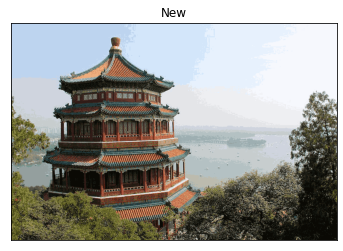

In [74]:
c = new_colors.reshape(china.shape)
ax = plt.axes(xticks=[], yticks=[])
ax.set_title('New')
ax.imshow(c);

In [70]:
# 3 paragaph justification of method

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

In [80]:
from sklearn import preprocessing

data_url = r'data/college.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
priv = df.Private


# parse yes as 1, no as 0
y = df.Private.map(dict(Yes=1, No=0))
df = df.drop(['Private','Unnamed: 0'], 1)
X = df.copy()

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [81]:
N_CLUSTERS=2 
km = clu.KMeans(n_clusters=N_CLUSTERS)

km.fit(X)
pred = km.predict(X)

In [82]:
accuracy_score(y,pred)

0.7786357786357786

In [83]:
confusion_matrix(y, pred)

array([[ 74, 138],
       [ 34, 531]], dtype=int64)

TypeError: '(slice(None, None, None), 0)' is an invalid key